## Is it a bird?

In [1]:
# #NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
# #    This code is only here to check that your internet is enabled. It doesn't do anything else.
# #    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

# import socket,warnings
# try:
#     socket.setdefaulttimeout(1)
#     socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
# except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# # It's a good idea to ensure you're running the latest version of any libraries you need.
# # `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# # NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
# import os
# iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# if iskaggle:
#     !pip install -Uqq fastai duckduckgo_search

# Steps:

1. Use DuckDuckGo to search for images of "bird photos"
2. Use DuckDuckGo to search for images of "forest photos"
3. Fine-tune a pretrained neural network to recognise these two groups
4. Try running this model on a picture of a bird and see if it works.

In [11]:
from fastcore.all import *
from duckduckgo_search import DDGS
from fastdownload import download_url
from fastai.vision.all import *
import torch

device  = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Step 1: Download images of birds and non-birds

In [24]:
def search_images(term, max_images = 30):
    search_results = []
    all_searches = DDGS().images(keywords = term)
    counter = 0
    for r in all_searches:
        if counter==max_images:
            break
    
        search_results.append(r)
        counter+=1
        
    return L(search_results).itemgot('image')


# ----  L ----
# L is a very powerful user-friendly function - to intuitively handle lists, dictionary, arrays and specially for DataFrame (which requires lots 
# of syntax for modification.) With L, Dataframe can be edited easily without worrying about syntax too much.

# --- ddg_images ----
# Here, ddg_images -> returns a list of dictionary where key 'image' has https: link to image and .itemgot gets that URL link 
# We have only got the URLs with this function and didn't downloaded the images

In [25]:
cat_urls = search_images('cat', max_images=2)
cat_urls

(#2) ['https://get.pxhere.com/photo/animal-pet-kitten-cat-small-mammal-fauna-heal-blue-eye-close-up-nose-whiskers-vertebrate-domestic-lying-tabby-cat-norwegian-forest-cat-ginger-fur-small-to-medium-sized-cats-cat-like-mammal-carnivoran-domestic-short-haired-cat-domestic-long-haired-cat-609263.jpg','https://wallpaperaccess.com/full/275808.jpg']

...and then download a URL and take a look at it:

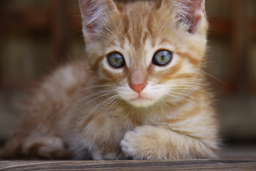

In [26]:
dest = 'cat.png'
download_url(cat_urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

In [27]:
?download_url

Now let's do the same with "forest photos":

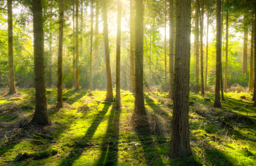

In [28]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [37]:
?download_images # uses preserve_filenames  = False  : because many cat images can have name cat.jpg on internet server. So
                 # fast ai in this case give them a unique identifier using ' uuid.uuid4()' in source code

In [38]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

In [39]:
?resize_images

In [40]:
?sleep

In [41]:
?verify_images

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [42]:
?get_image_files

In [45]:
failed = verify_images(get_image_files(path)) # input to verify_images is fastai L class i.e. a list of paths
failed.map(Path.unlink)
len(failed)

3

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

In [48]:
doc(parent_label)  # return Path(o).parent.name

In [84]:
# sample :
sample_path = get_image_files(path)[0]
print(sample_path)
print(sample_path.parent.name)
#OR
print(parent_label(sample_path))
print('All parents ->', sample_path.parent.parts)


# To see all attributes: Use dir
dir(sample_path)

# For customised level 
def parent_label_level(o ,level=0):
    '''Label `item` with the Immediate parent folder name.'''
    total = len(Path(o).parent.parts)
    return Path(o).parent.parts[total-1-level]
print('level 0 :', parent_label_level(sample_path, level=0),'  level 1 :', parent_label_level(sample_path, level=1))

bird_or_not\bird\0403c122-5a48-48e8-b873-219f79c4a962.jpg
bird
bird
All parents -> ('bird_or_not', 'bird')
2
2
level 0 : bird   level 1 : bird_or_not


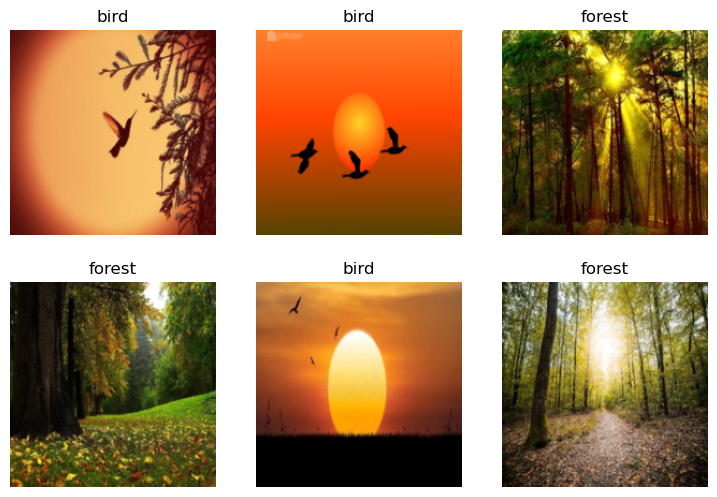

In [85]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

# DataBlock has 5 items:
# a) blocks = (Input type, Output type)
# b) get_items = a function
# c) splitter = validation set            # More details in Lesson-6
# d) get_y = correct labels
# e) item_tfms = every input of same size

# show_batch : displays name or label as defined in "get_y"

# Tip-1 : Use small size images as usually most time is taken in opening images while training a NN takes much lesser time.

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [86]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

C:\ProgramData\Anaconda3\envs\ai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\ai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.105135,0.065551,0.030303,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.181547,0.049927,0.030303,00:01
1,0.099350,0.079205,0.030303,00:00
2,0.076606,0.101390,0.030303,00:00


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [103]:
# get the vocabulary
print(learn.dls.vocab)
print('0 represents: ', learn.dls.vocab[0], ' 1 represents: ', learn.dls.vocab[1])

['bird', 'forest']
0 represents:  bird  1 represents:  forest


In [88]:
class_name, predicted_label, softmax_probs = learn.predict(Path('forest.jpg'))
print('class name: ', class_name, ' predicted label: ',predicted_label, 'softmax probs: ' , softmax_probs)

# Can also use this in future
print('Probability of {} is {}'.format(class_name, softmax_probs[predicted_label]))


class name:  forest  predicted label:  tensor(1) softmax probs:  tensor([1.8094e-05, 9.9998e-01])
Probability of forest is 0.9999818801879883


In [89]:
learn.export('bird_forest_classifier.pkl')

In [90]:
# let's see how size of weight files change when I use resnet50: I guess it will be around 100 MB

learn_2 = vision_learner(dls, resnet50, metrics=error_rate)
learn_2.fine_tune(3)
learn_2.export('bird_forest_classif_resnet50.pkl')

C:\ProgramData\Anaconda3\envs\ai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\ai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.784048,0.000747,0.000000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.039037,0.006025,0.000000,00:01
1,0.070831,0.067278,0.030303,00:01
2,0.052653,0.099047,0.030303,00:01


# Model size comparison
- Resnet18 model - 45 MB
- Resnet50 model - 100 MB


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.